# Using EDHEC Risk Kit Part 2
### Explore use of the library to:
- calculate monthly parametric guassian VaR
- calculate monthly parametric gaussian VaR with Cornish-Fisher Adjustment
- build MSR and GMV portfolios
- calculate annual volatility of a portfolio containing multiple assets
- plot the efficient frontier given a set of assets
- calculate portfolio weights to achieve target return while minimizing volatility

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
%matplotlib inline

### Load the hedge fund index returns
- Considers years from 1980 to 2015

In [2]:
hfi = erk.get_hfi_returns()['1980':'2015']

### What was the Monthly Parametric Gaussian VaR at the 1% level of the Emerging Markets strategy?

In [3]:
erk.var_gaussian(hfi['Emerging Markets'], level=1)

0.0727702691677074

### What was the Monthly Parametric Gaussian VaR at the 1% level of the Emerging Markets strategy with the Cornish-Fisher Adjustment?

In [4]:
erk.var_gaussian(hfi['Emerging Markets'], level=1, modified=True)

0.13051127699820947

### What was the Monthly Historic VaR at the 1% level of the Emerging Markets strategy?

In [5]:
erk.var_historic(hfi['Emerging Markets'], level=1)

0.093961

### Load industry returns from 1980 to 2015
- Consider the Finance, Utility, Telecom, and Health industries

In [6]:
cols = ['Fin', 'Util', 'Telcm', 'Hlth']
ind = erk.get_ind_returns().loc['1980':'2015', cols]

### Calculate the weights for the maximum Sharpe ratio portfolio

In [7]:
er = erk.annualize_rets(ind, periods_per_year=12)
cov = ind.cov()
w_msr = erk.msr(riskfree_rate=0.02, er=er, cov=cov)
pd.DataFrame(w_msr, index=cols, columns=['Shape Ratio Weight'])

,Shape Ratio Weight
Fin,0.000000
Util,0.454315
Telcm,0.061605
Hlth,0.484080


### Calculate the weights for the global minimum variance portfolio

In [8]:
w_gmv = erk.gmv(cov=cov)
pd.DataFrame(w_gmv, index=cols, columns=['GMV Weight'])

,GMV Weight
Fin,0.000000
Util,0.581040
Telcm,0.169712
Hlth,0.249248


### Compare the annualized volatility of the MSR and GMV portfolios (weights calculated from data from 1980 to 2015) from 2016 to 2018

In [9]:
ind = erk.get_ind_returns().loc[:, cols]

er = erk.annualize_rets(
    ind['1980':'2015'], 
    periods_per_year=12
)

cov = ind['1980':'2015'].cov()
w_msr = erk.msr(riskfree_rate=0.02, er=er, cov=cov)
w_gmv = erk.gmv(cov=cov)

vol_msr = np.sqrt(12)*erk.portfolio_vol(
    weights=w_msr, 
    covmat=ind['2016':'2018'].cov()
)
vol_gmv = np.sqrt(12)*erk.portfolio_vol(
    weights=w_gmv, 
    covmat=ind['2016':'2018'].cov()
)

print('MSR 2016-2018 variance:', vol_msr)
print('GMV 2016-2018 variance:', vol_gmv)

MSR 2016-2018 variance: 0.0968449984016509
GMV 2016-2018 variance: 0.08990557036497361


### Calculate the annualized returns of the these two portfolios from 2016 to 2018

In [10]:
r = erk.annualize_rets(
    ind['2016':'2018'], 
    periods_per_year=12
)

r_msr = erk.portfolio_return(
    weights = w_msr, 
    returns = r
)

r_gmv = erk.portfolio_return(
    weights = w_gmv,
    returns = r
)

print('MSR 2016-2018 return:', r_msr)
print('GMV 2016-2018 return:', r_gmv)

MSR 2016-2018 return: 0.08369298270843524
GMV 2016-2018 return: 0.08893150684183913


In [12]:
ind.head()

,Fin,Util,Telcm,Hlth
1926-07,0.0037,0.0704,0.0083,0.0177
1926-08,0.0446,-0.0169,0.0217,0.0425
1926-09,-0.0123,0.0204,0.0241,0.0069
1926-10,-0.0516,-0.0263,-0.0011,-0.0057
1926-11,0.0224,0.0371,0.0163,0.0542


### Plot the efficient frontier for a portfolio considering 2 assets, Finance and Utilities stocks, based on evaluation from 1980 to 2015

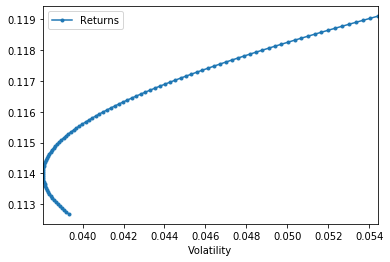

In [14]:
er = erk.annualize_rets(
    ind['1980':'2015'], 
    periods_per_year=12
)

erk.plot_ef2(
    100,
    er=er[['Fin', 'Util']],
    cov=ind.loc['1980':'2015', ['Fin', 'Util']].cov()
)

### Plot the efficient frontier for a portfolio considering 4 assets: Finance, Utilities, Telecom, and Health stocks, based on evaluation from 1980 to 2015

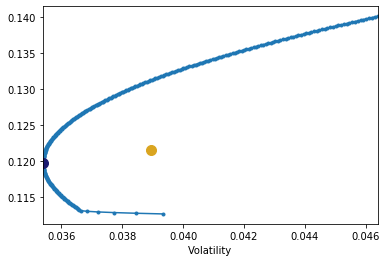

In [19]:
er = erk.annualize_rets(
    ind['1980':'2015'], 
    periods_per_year=12
)

erk.plot_ef(
    300, 
    er=er, 
    cov=ind.loc['1980':'2015', cols].cov(), 
    show_ew=True,
    show_gmv=True
)

### Considering the industries in the 30 industry returns data from 1960 to 2015, calculating the asset weights that minimize volatility which achieving a target return of 12%

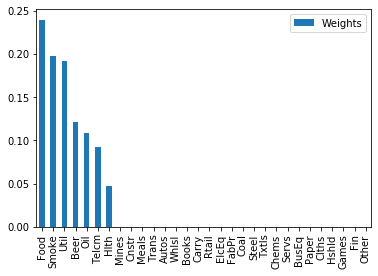

In [28]:
ind = erk.get_ind_returns(n_inds=30)

er = erk.annualize_rets(
    ind['1960':'2015'], 
    periods_per_year=12
)

weights = erk.minimize_vol(
    target_return=0.12,
    er=er,
    cov=ind['1960':'2015'].cov()
)

weights_df = pd.DataFrame(weights, index=ind.columns, columns=['Weights'])
weights_df.sort_values('Weights', ascending=False).plot.bar()